### ANALYTIC SOLUTION FOR SCALAR WAVE 2D FREE SPACE ###

Based on Alford 1974 Geophysics. 
"ACCURACY OF FINITE-DIFFERENCE MODELING OF THE ACOUSTIC WAVE EQUATION"

Using cylindrical coordinates for a free a space medium homogeneous of velocity **$v$**. If the observer is at a **$\rho$** distance from the source. The analytical solution is written from the frequency domain solution as:

$$
U(\rho, t) = \frac{1}{2\pi}\int_{-\inf}^{+\inf}-F(\omega) i\pi H^{(2)}_{0}(k\rho)
$$

where $F(\omega)$ is the fourier transform of the source
function $f(t)$

$H^{(2)}$ is the second Hankel function of order 0

and $k = \omega/v $


###Source###

To avoid and diminish numerical errors we can use a source with analytical fourier transform known 

For simplicity on above equation we can use a simple Gauss Pulse:

$$ f(t) = te^{-\alpha t^2} $$ 

and its Fourier Transform $F(\omega)$ (note: in Alford's paper it was a bit different, I trust this one from Wolfram)

$$ F(\omega) = \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)}
$$

So simplifying the first one we get:

$$ U(\rho, t) = -i\pi H^{(2)}_{0}(k\rho_s)  \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

$$ U(\rho, t) =  H^{(2)}_{0}(k\rho_s)  \frac{\omega\pi}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

### About the numerical implementation of the analytical solution ###

A discussion should be made to how calculate the error of an analytical solution for 2D free space implemented numerically.
The way the error calculation is implemented now is based on peaks or throughs of the original (t=0) pulse. That might not be a good measurament for velocity/for getting error. Since spherical loss of energy is expected so peaks or throughs might get smoother or displaced.  

Despite all that:

There seams that error is associated with the pulse size. If the pulse is shorter the error gets smaller. Also associated with sample rate. But playing with that (pulse size and dt) making it as small as possible makes error go to less than 0.5%. Also  not be a good measurament for velocity/for getting error.

Fixed implementation: frequency increments were wrong. 

Errors < 0.5% 

===========================================================================================================


A better method to calculate error (or the best method I can think of) could be to use a gaussian pulse and analyse just the peak (pulse of energy).<br/>  The pulse of energy is expected to travel with the exact wave velocity.

$$ f(t) = e^{-\alpha*t^2} $$

Where its fourier transform is:

$$ F(\omega) = \frac{e^{-\frac{\omega^2}{4 k}}}{ \sqrt{2k} } $$

For reasons I can not tell the analytical solution for a gaussian pulse gets weird allways. 
Don't know if it's related to non-stationarity of it. 


============================================================================================================

Best analytical solution found so far is using the Ricker source in time.

$$ f(t) = (1-2\left(\pi f_M t\right)^2)e^{-\left(\pi f_M t\right)^2} $$

$$ F(\omega) = \frac{ \omega^2 e^{-\left(\frac{\omega^2}{4\pi^2 f_M^2}\right)} }{ 2\sqrt{2} \pi^3 f_M^3 }$$


$$ U(\rho, t) =  -iH^{(2)}_{0}(k\rho_s)  \frac{ \omega^2 e^{-\left(\frac{\omega^2}{4\pi^2 f_M^2}\right)} }{ 2\sqrt{2} \pi^3 f_M^3 }  $$

<br/>
<br/>
<br/>

#### Analytical solution error can be as low as 0% depending on sample rate, if its value is multiple of velocity/distance. ####

============================================================================================================





In [93]:
%pylab inline

import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Using totally analytical solution in frequency domain Gauss Pulse of Alford ###

In [107]:
from scipy.special import hankel2
import numpy as np

def free_2d_analytic_gauss(rho, c, dt, n, alpha):
    """
    Analytic solution equation Alford et. al. cylindrical coordinates
    2D free space. Source function is a gauss pulse locate at zero. 
    
    note: dot not evaluate at zero, solution not viable
    
    rho - distance to the source function
    c - velocity    
    dt - sample rate for time solution
    n - number of samples of time solution
    alpha - alpha argment for gauss source
    
    """
    #ws = np.fft.fftfreq(n, dt)*np.pi
    # omega (2pi*f) increment for each omega that will be sampled
    ws = np.pi*2*np.arange(0, (1./dt), (1./dt)/n) 
    # all k's = w/c in omega/frequency domain to evaluate the solution     
    ks = ws/c
    hankel = hankel2(0, ks*rho) # low pass shift filter (spherical/2d divergence)??? just thinking
    #hankel = hankel2_0(ks*rho)
    hankel[0] = 1. # i infinity in limit
    # better math simplifying I could make
    sourcew = (ws*0.5*np.pi)/((alpha**(1.5))*np.sqrt(2))#  gauss source in the frequency domain  
    sourcew *= np.exp(-(ws**2)/(4*alpha)) 
    return np.real(np.fft.ifft(hankel*sourcew))

In [94]:
from scipy.special import hankel2
import numpy as np

def free_2d_analytic_gauss(rho, c, dt, n, alpha):
    """
    Analytic solution equation Alford et. al. cylindrical coordinates
    2D free space. Source function is a gauss pulse locate at zero. 
    
    note: dot not evaluate at zero, solution not viable
    
    rho - distance to the source function
    c - velocity    
    dt - sample rate for time solution
    n - number of samples of time solution
    alpha - alpha argment for gauss source
    
    """
    #ws = np.fft.fftfreq(n, dt)*np.pi
    # omega (2pi*f) increment for each omega that will be sampled
    ws = np.pi*2*np.arange(0, (1./dt), (1./dt)/n) 
    # all k's = w/c in omega/frequency domain to evaluate the solution     
    ks = ws/c
    hankel = hankel2(0, ks*rho) # low pass shift filter (spherical/2d divergence)??? just thinking
    hankel[0] = 1. # i infinity in limit
    # better math simplifying I could make
    sourcew = (ws*0.5*np.pi)/((alpha**(1.5))*np.sqrt(2))#  gauss source in the frequency domain  
    sourcew *= np.exp(-(ws**2)/(4*alpha)) 
    return np.real(np.fft.ifft(hankel*sourcew))

In [105]:
import numpy as np

# alford gauss source has a known solution analytical on frequency
def gauss(time, alpha, delay=0):
    t = time-delay
    return time*np.exp(-alpha*time**2)    

estimated velocity 1485.88410104
error % 0.941059930659
660 686


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


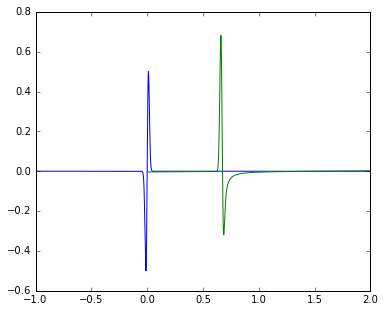

In [118]:
from scipy import signal

velocity = 1500
dt = 0.001
distance = 1000. # distance to source to calculate analytical solution
alpha = 4000 # controls how spread is the wavelet
t = np.arange(-1., 2.0, dt)
tp = np.arange(0, 2.0, dt)
y = gauss(t, alpha)
y = (y - y.min())/(y.max()-y.min())
y = signal.detrend(y)
asolution = free_2d_analytic_gauss(distance, velocity, dt, tp.size, alpha)
x = asolution
x = signal.detrend(x)
x = (x - x.min())/(x.max()-x.min())
x = signal.detrend(x)

figure(figsize=(6,5))
plot(t, y) # showing full solution
plot(tp, x)
# try to get the pulse center (center of energy)
v_analytic =  distance/((x.argmax()+x.argmin())*0.5*dt) # -y.argmax() it is unecessary since it  was in the 0
print "estimated velocity", v_analytic
print "error %", (abs(v_analytic-velocity)/velocity)*100
print x.argmax(), x.argmin(), 

### Using fully analytical solution in frequency domain Ricker Wavelet ###





$$ F(\omega) = \frac{ \omega^2 e^{-\left(\frac{\omega^2}{4\pi^2 f_M^2}\right)} }{ 2\sqrt{2} \pi^3 f_M^3 }$$

In [83]:
from scipy.special import hankel2
import numpy as np

def free_2d_analytic_ricker(rho, c, dt, fm, n):
    """
    Analytic solution equation Alford et. al. cylindrical coordinates
    2D free space. Source function is a gauss pulse locate at zero. 
    
    note: dot not evaluate at zero, solution not viable
    
    rho - distance to the source function
    c - velocity    
    dt - sample rate for time solution
    n - number of samples of time solution
    fm - 
    
    """
    if rho/c > dt*n:
        raise Exception("n must be bigger (at least big than (velocity/distance) by dt "
            +str(rho/(c*dt)))
    #ws = np.fft.fftfreq(n, dt)*np.pi
    # omega (2pi*f) increment for each omega that will be sampled
    ws = np.pi*2*np.arange(0, (1./dt), (1./dt)/n) 
    # all k's = w/c in omega/frequency domain to evaluate the solution     
    ks = ws/c
    hankel = -1j*hankel2(0, ks*rho) # low pass shift filter (spherical/2d divergence)??? just thinking
    hankel[0] = 1. # i infinity in limit
    # better math simplifying I could make
    sourcew = (ws**2)*np.exp(-(ws**2)/(4*(np.pi*fm)**2))
    sourcew /= 2*np.sqrt(2)*(np.pi**2)*fm**3
    return np.real(np.fft.ifft(hankel*sourcew))

In [84]:
def peak_verror(velocity, distance, dt,  s_analytic, verbose=False):
     # it  was in the 0 at t=0
    v_analytic =  distance/((s_analytic.argmax())*dt)
    err = (abs(v_analytic-velocity)/velocity)*100
    if verbose:
        print "estimated velocity", v_analytic
        print "error %", err
    return err

estimated velocity 1491.64677804
error % 0.556881463803


0.55688146380269554

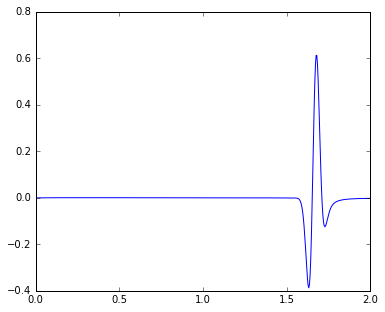

In [85]:
from scipy import signal

velocity = 1500
distance = 2500. # distance to source to calculate analytical solution
dt = 0.004
fm = 9 # controls central frequency ricker

t = np.arange(0., 2.0, dt)
asolution = free_2d_analytic_ricker(distance, velocity, dt, fm, t.size)
x = asolution
x = signal.detrend(x)
x = (x - x.min())/(x.max()-x.min())
x = signal.detrend(x)
figure(figsize=(6,5))
plot(t, x)

peak_verror(velocity, distance, dt, x, True)

### Calculate the error associate with the analytical solution for different distances ###

The analytical error also associated with frequency of the ricker source, its velocity, sample rate and number of samples.

**So make one fixed and vary others to evaluate the errors**

The ideal would be a monte carlo sensitivity analysis

In [86]:
def error_vpeak_ricker_analytic(distance, velocity, fm, dt, n):
    t = linspace(0, n*dt, n)
    analytic = free_2d_analytic_ricker(distance, velocity, dt, fm, t.size)
    return peak_verror(velocity, distance, dt, analytic)

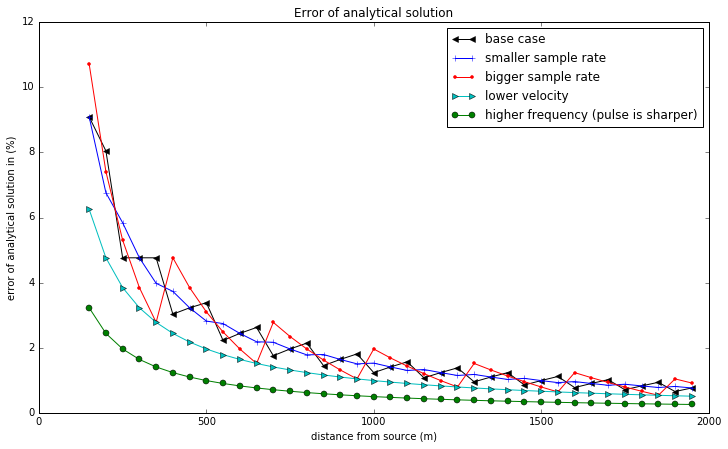

In [87]:
import functools

figure(figsize(12, 7))

y = map(functools.partial(error_vpeak_ricker_analytic, velocity=1500, fm=10, dt=0.005, n=40000), 
        arange(150, 2000, 50))

y1 = map(functools.partial(error_vpeak_ricker_analytic, velocity=1500, fm=10, dt=0.001, n=40000), 
        arange(150, 2000, 50))

y2 = map(functools.partial(error_vpeak_ricker_analytic, velocity=1500, fm=10, dt=0.008, n=40000), 
        arange(150, 2000, 50))

y4 = map(functools.partial(error_vpeak_ricker_analytic, velocity=1000, fm=10, dt=0.005, n=40000), 
        arange(150, 2000, 50))          

y3 = map(functools.partial(error_vpeak_ricker_analytic, velocity=1000, fm=25, dt=0.005, n=40000), 
        arange(150, 2000, 50)) 


plot(arange(150, 2000, 50), y, 'k<-', label='base case') # base case
plot(arange(150, 2000, 50), y1, 'b+-', label='smaller sample rate') #
plot(arange(150, 2000, 50), y2, 'r.-', label='bigger sample rate') # bigger sample rate
plot(arange(150, 2000, 50), y4, 'c>-', label='lower velocity') 
plot(arange(150, 2000, 50), y3, 'og-', label='higher frequency (pulse is sharper)') # higher frequency pulse is sharper\

xlabel('distance from source (m)')
ylabel('error of analytical solution in (%)')
title('Error of analytical solution')
legend()

### Using partially analytical solution in frequency domain Ricker Wavelet ###


The wavelet is created in time then fourier transformed to frequency to apply<br/> 
the analytical solution and then apply back the inverse fourier transform to get it back to time

In [88]:
from scipy.special import hankel2
import numpy as np

def free_2d_analytic_s(rho, c, dt, st):
    """
    Analytic solution equation Alford et. al. cylindrical coordinates
    2D free space. 
    
    note: dot not evaluate at zero, solution not feasible
    
    rho - distance to the source function
    c - velocity    
    dt - sample rate for time solution
    st - source in time
    
    """
    n = st.size
    if rho/c > dt*n:
        raise Exception("n must be bigger (at least big than (velocity/distance) by dt "
                        +str(rho/(c*dt)))
    # omega (2pi*f) increment for each omega that will be sampled
    ws = np.pi*2*np.arange(0, (1./dt), (1./dt)/n) 
    # all k's = w/c in omega/frequency domain to evaluate the solution     
    ks = ws/c
    hankel = -1j*np.pi*hankel2(0, ks*rho) # low pass shift filter (spherical/2d divergence)??? just thinking
    hankel[0] = 1. # i infinity in limit
    # just go to frequency
    sw = np.fft.fft(st)
    return np.real(np.fft.ifft(hankel*sw))

In [89]:
def peak_verror(velocity, distance, dt,  s_analytic, st, verbose=False):
     # it  was in the 0 at t=0
    v_analytic =  distance/((s_analytic.argmax()-st.argmax())*dt)
    err = (abs(v_analytic-velocity)/velocity)*100
    if verbose:
        print "estimated velocity", v_analytic
        print "error %", err
    return err

In [90]:
def error_vpeak_analytic(distance, velocity, dt, st):
    n = st.size
    t = linspace(0, n*dt, n)
    analytic = free_2d_analytic_s(distance, velocity, dt, st)
    return peak_verror(velocity, distance, dt, analytic, st)

In [91]:
%cd Fatiando 

from fatiando.seismic import wavefd

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


### Calculate the error associate with the analytical solution for different distances ###

Varying again the parameters, dt, vc, n

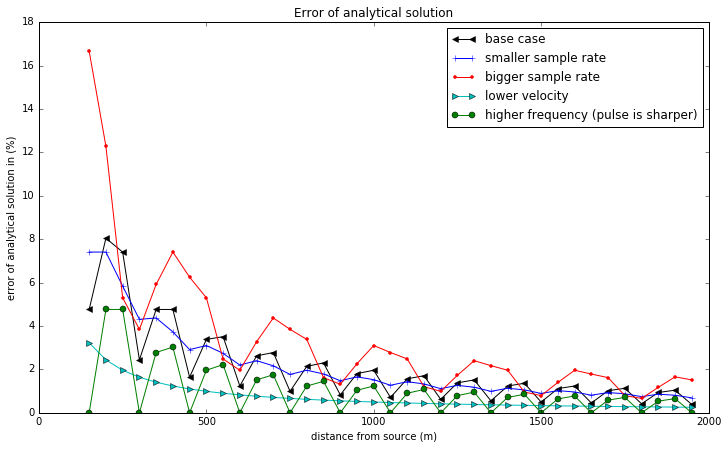

In [92]:
import functools

figure(figsize(12, 7))

fc = 10.0
dt = 0.005
fricker = wavefd.Ricker(1., fc, 1./fc)
t = np.arange(0.0, 200.0, dt)
y = map(functools.partial(error_vpeak_analytic, velocity=1500, dt=dt, st=fricker(t)), 
        arange(150, 2000, 50))

fc = 10.0
dt = 0.001
fricker = wavefd.Ricker(1., fc, 1./fc)
t = np.arange(0.0, 40.0, dt)
y1 = map(functools.partial(error_vpeak_analytic, velocity=1500, dt=dt, st=fricker(t)), 
        arange(150, 2000, 50))

fc = 10.0
dt = 0.008
fricker = wavefd.Ricker(1., fc, 1./fc)
t = np.arange(0.0, 320.0, dt)
y2 = map(functools.partial(error_vpeak_analytic, velocity=1500, dt=dt, st=fricker(t)), 
        arange(150, 2000, 50))


fc = 10.0
dt = 0.005
fricker = wavefd.Ricker(1., fc, 1./fc)
t = np.arange(0.0, 200.0, dt)
y4 = map(functools.partial(error_vpeak_analytic, velocity=1000, dt=dt, st=fricker(t)), 
        arange(150, 2000, 50))


fc = 25.0
dt = 0.005
fricker = wavefd.Ricker(1., fc, 1./fc)
t = np.arange(0.0, 200.0, dt)
y3 = map(functools.partial(error_vpeak_analytic, velocity=1500, dt=dt, st=fricker(t)), 
        arange(150, 2000, 50))


plot(arange(150, 2000, 50), y, 'k<-', label='base case') # base case
plot(arange(150, 2000, 50), y1, 'b+-', label='smaller sample rate') #
plot(arange(150, 2000, 50), y2, 'r.-', label='bigger sample rate') # bigger sample rate
plot(arange(150, 2000, 50), y4, 'c>-', label='lower velocity') 
plot(arange(150, 2000, 50), y3, 'og-', label='higher frequency (pulse is sharper)') # higher frequency pulse is sharper\

xlabel('distance from source (m)')
ylabel('error of analytical solution in (%)')
title('Error of analytical solution')
legend()

###Conclusion####
   
To use the analytical solution:
    
1. Use the velocity as low as possible.

2. Use the frequency as high as possible

3. Use the sample rate as small as possible

4. Use a distance from the source as far as possible 

5. Calculate the expected curve of error for every distance 

You can use either full analytical solution in frequency or partially in frequency<br/> Altough the last one can be used also to compare loss of energy with distance and the first not. 

So it's recommended to use the partially time / partially frequency analytical solution implementation.

Then you are able to compare and check how reliable is your F.D. using the error curve. 

###Simple grid F.D. free space testing###

In [19]:
%cd Fatiando

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


In [72]:
"""
Seismic: 2D finite difference simulation of scalar wave
"""

from fatiando.seismic import wavefd
import numpy as np

vc=2500.
vshape = (400, 50)
mvel = np.ones(vshape)*vc
dx = dz = 5.
eps = 0.98*1./(5*max(dx, dz)*min(1./(2*dx),1./(2*dz)))
fc = eps*np.min(mvel)/(max(2*dx, 2*dz)) 
fc = fc/4. # frequency spectrum of Ricker is very broad fc is the peak 
xs, zs = 25.0, 60.0 # source (makes a lot of difference if u put close to z=0 (free up-surface problem))
xb, zb = 25.0, 385.0 # receivers

sim = wavefd.Scalar(mvel, (dx, dz))
sim.add_point_source((xs, zs), wavefd.Ricker(1., fc, 1./fc))

In [73]:
sim.run(850)
print "sample rate (s) ", sim.dt, " max time (s) ", sim.simsize*sim.dt

|##################################################|100% Ran 850 iterations in 13.956 seconds.

sample rate (s)  0.00121249742268  max time (s)  1.03062280928


analytical error expected (%)  0.356205624456


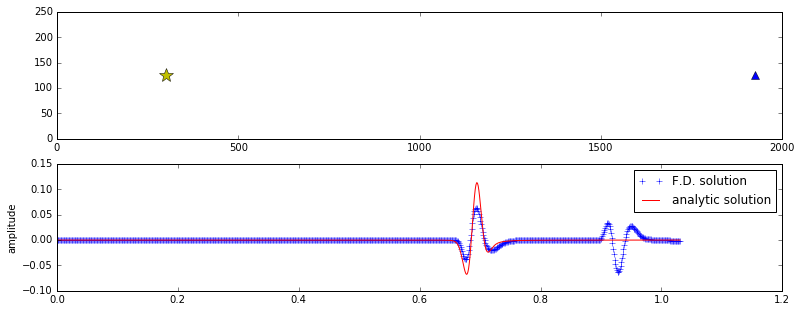

In [74]:
figure(figsize(13,5))
subplot(211)
plot(zb*dz, xb*dx, 'b^', markersize=8)
plot(zs*dz, xs*dx, '*y', markersize=15) 
xlim(0, vshape[0]*dz)
ylim(0, vshape[1]*dx)

subplot(212)
sensor_b = sim[:, zb, xb]
t = np.linspace(0., sim.simsize*sim.dt, sim.simsize)
wfricker = wavefd.Ricker(1., fc, 1./fc)
analytic_b = free_2d_analytic_s((zb-zs)*dx, vc, sim.dt, wfricker(t))
plot(t, sensor_b,'b+', label='F.D. solution') 
plot(t, analytic_b, 'r-', label='analytic solution')
ylabel('amplitude')
legend()

fricker = wavefd.Ricker(1., fc, 1./fc)
print "analytical error expected (%) ", error_vpeak_analytic((zb-zs)*dx, velocity=vc, dt=sim.dt, st=fricker(t))

## F. D. different type of errors ##


1. Errors due time shift (F.D. time derivative error in aproximation - just 2nd order)

2. Error due energy or amplitude loss (F.D. numerical dispersion - spatial derivatives or all derivatives)<br/> 
    G value based on wave number (Alford) greatly controls numerical dispersion.
    
3. Error due energy loss for different frequencies

#### Calculate time shift error ####

#### Calculate energy amplitude loss ####

time shift error is (s)  -0.00121249742268 in samples (n)  1
relative time shift error is (%) 0.174825 


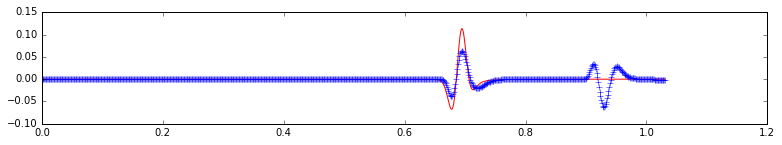

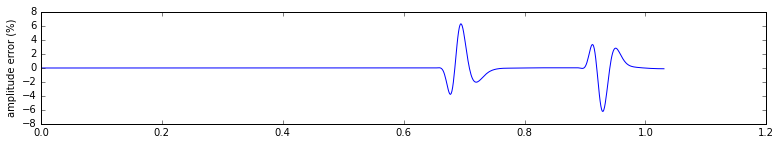

In [76]:
xycor = np.correlate(analytic_b, sensor_b, mode='full')
sample_time_shit = (xycor.argmax()-size(analytic_b))+1
print "time shift error is (s) ", -(sample_time_shit*sim.dt), "in samples (n) ", sample_time_shit
print "relative time shift error is (%) "+"%f "%(100.*sample_time_shit/analytic_b.argmax())

from collections import deque # shift in time to calculate energy loss
sensor_b_r = deque(sensor_b)
sensor_b_r.rotate(sample_time_shit)
sensor_b_r = np.array(sensor_b_r)

figure(figsize(13,2))
plot(t, analytic_b, 'r')
plot(t, sensor_b_r, 'b+')
figure(figsize(13,2))
relative_amp = (sensor_b_r+1.)-(analytic_b+1.)/(analytic_b+1.) # to avoid division by zero
plot(t, 100*relative_amp) # have to fix this. Find a better way to calculate
# amplitude error.
ylabel('amplitude error (%)')

### Make a graph of source position and time shift error ###

I guess that the closer to the grid boundary worse it is. 

Need to implement absorbing boundaries everywhere like di bartolo also 
padding and everything.

The source should not be at z=0, 1, or 2. Should be far from any grid boundary. 

If someone wants, just put water velocity above. I guess the the free earth is more closer to a absorbing boundary than to anything else. 

In [610]:
"""
Seismic: 2D finite difference simulation of scalar wave
"""
%cd Fatiando
%pylab inline
from fatiando.seismic import wavefd
import numpy as np

# Set the parameters of the finite difference grid
vshape = (200, 200)
ds = dx = dz = 12.5 # spacing
area = [0, vshape[0]*dz, 0, vshape[1]*dx]
# Set the parameters of the finite difference grid
vc=200.0
mvel = np.zeros(vshape)+vc
mvel[100:,100:] = 0.

# source frequency ? waveleght w = 0.0 second
eps = 0.98*1./(4*max(dx, dz)*min(1./(2*dx),1./(2*dz)))
fc = eps*vc/(max(2*dx, 2*dz))  
dt = wavefd.scalar_maxdt(area, vshape, np.max(mvel))

# Alford adapted by André
xs, zs = 107.0, 93.0 # source
# receivers
xa, za = 105.0, 95.0 # A - delta 7 - epsilon 2
xb, zb = 93.0, 93.0 # mirrored source positon to left
xc, zc = 97.0,105 # difraction


# Make a wave source from a mexican hat wavelet
#sources = [wavefd.MexHatSource(30000, 15000, area, shape, 100, fc, delay=2)]
# Make a wave source from a mexican hat wavelet, delay=3.5*wavelength
# first example R. M. Alford (x, z) 
sources = [wavefd.GaussSource((xs*ds, zs*ds), area, vshape,  1., fc)]

# Get the iterator for the simulation
#dt = wavefd.maxdt(area, shape, velocity)

maxt = 5.000
maxit = int(maxt/dt)
stations = [[xa*ds, za*ds], [xb*ds, zb*ds], [xc*ds, zc*ds]] # x, z coordinate of the seismometers
snapshot = 1 # Plot a snapshot of the simulation every 0.5 seconds
simulation = wavefd.scalar(mvel, area, dt, maxit, sources, stations=stations, snapshot=snapshot)

vmin = vmax = np.max(mvel)
vmin = vmax

R = dt*vmax/ds
print "fc :", fc, " maxit ", maxit
print "vmin : ", vmin, " vmax : ", vmax
print "R : ", R, "  of allowed < : ", np.sqrt(3./8.)  
print "Dt : ",  dt, "  of allowed < :", np.sqrt(3./8.)*ds/vmax
# Dave Hale criteria for dt
print "Dave Hale dt", ds/(2.*vmax)
print "Points by wavelenght: ", vmax/fc/ds, " recommended > 5 "
# the definition above of points by wavelength is not quite rigth is not using the
# spectrum fourier spectrum. 
print "Is there spatial Alias (based on frequency)? ", (vmax/fc < 2*ds)

figure(figsize(8,8))
imshow(mvel, origin='upper')
plot(xa, za, 'b^', markersize=8)
plot(xb, zb, 'g^', markersize=8)
plot(xc, zc, 'r^', markersize=8)
plot(xs, zs, '*y', markersize=15) 
xlim((0,200))
ylim((200,0))

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
Populating the interactive namespace from numpy and matplotlib


AttributeError: 'module' object has no attribute 'scalar_maxdt'

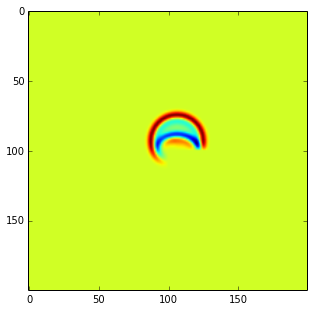

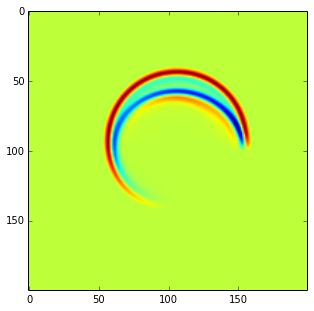

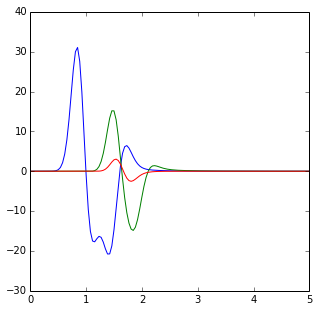

In [26]:
# numerical solution
frames = np.zeros((maxit, vshape[0], vshape[1]))
#
for i, frame, seismos in simulation:
    frames[i][:,:] = frame
    sensor_a = seismos[0]
    sensor_b = seismos[1]
    sensor_c = seismos[2]

figure(figsize=(5,5));
imshow(frames[48]); figure(figsize=(5,5));
imshow(frames[98]); figure(figsize=(5,5));#
hold(True);
t = np.linspace(0., maxit*dt, maxit)
plot(t, sensor_a,'b'); 
plot(t, sensor_b,'g'); 
plot(t, sensor_c,'r'); 
hold(False)

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando/fatiando/seismic
source:  9.89949493661 45.0
station:  7.07106781187 45.0
source:  9.89949493661 45.0
station:  9.89949493661 135.0
source:  9.89949493661 45.0
station:  5.83095189485 239.036243468


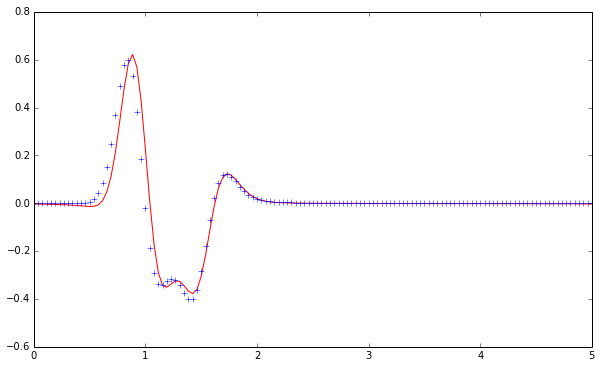

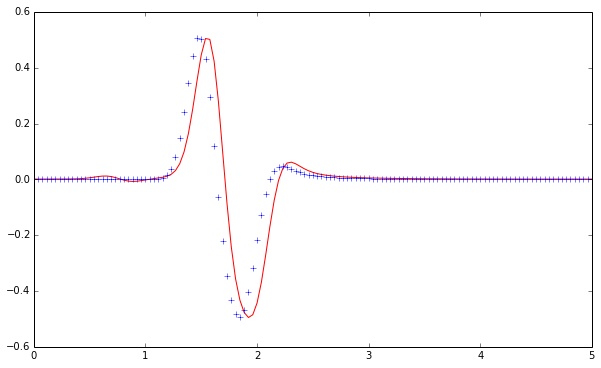

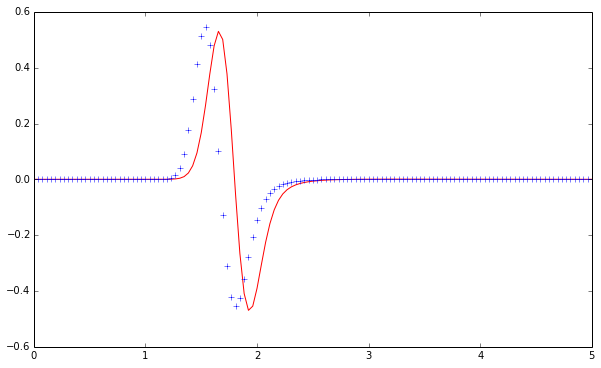

In [27]:
%cd Fatiando 
%cd fatiando/seismic
from analytic import wedge_cylindrical, _2cylindrical

def compare(fd_receiver, x, z, xs, zs, x0, z0, ds, vc, fc, dt, sources, maxt, maxit):
    rho_s, phi_s = _2cylindrical(xs, zs, x0, z0)
    rho, phi = _2cylindrical(x, z, x0, z0)
    print "source: ", rho_s, numpy.degrees(phi_s)
    print "station: ", rho, numpy.degrees(phi)
    sourcefunction = sources[0]
    t = np.linspace(0., maxt, maxit)
    source = -sourcefunction(t)    
    an_receiver = wedge_cylindrical(rho*ds, phi, rho_s*ds, phi_s, vc, source, dt)    
    fd_receiver = (fd_receiver-fd_receiver.min())/(fd_receiver.max()-fd_receiver.min())
    fd_receiver -= fd_receiver.mean()
    an_receiver = (an_receiver-an_receiver.min())/(an_receiver.max()-an_receiver.min())
    an_receiver -= an_receiver.mean()
    # plot fd and analytic solution
    pylab.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
    pylab.figure()
    plot(t,an_receiver,'r-')
    hold(True)
    plot(t,fd_receiver, 'b+')
    hold(False)
    pylab.rcParams['figure.figsize'] = 4, 4  # that's default image size for this interactive session

#ds = 100.
#vc = 6000.
#fc = 25.0
#dt = 0.01

compare(sensor_a, xa, za, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)
compare(sensor_b, xb, zb, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)
compare(sensor_c, xc, zc, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)

### Emulating 2D field using analytical solution for free space 2D###

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando/fatiando/seismic


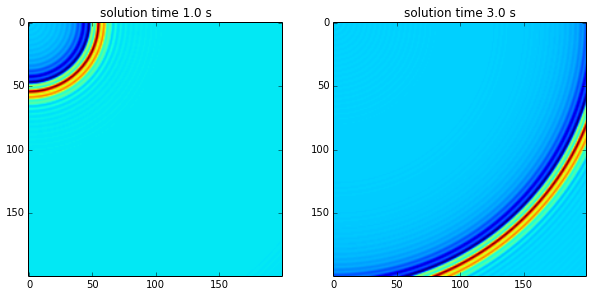

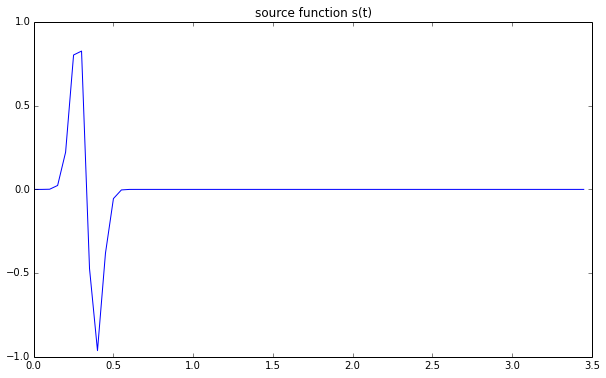

In [28]:
# Analytical solution 2D in math 
# answer posted in math.stackexchange 
# examples-of-2d-wave-equations-with-analytic-solutions/496611#496611

%cd Fatiando
%cd fatiando/seismic
from analytic import free_2d
import numpy as np

# a simple source function f(t) gauss derivative normalized
def gaussource(time, wlength, delay=None):
        if delay == None: # enough delay time
            delay = 3*wlength
        t = time - delay
        return ((2*np.sqrt(np.e)/(wlength))
               *t*np.exp(-2*(t**2)/(wlength**2)))

fc= 9.
c = 8000.
dt = 0.05
t = np.arange(0., 3.5, dt) # 35 seconds to evaluate the solution
source = -gaussource(t, 1./(fc)) # source and solution at zero source (source itself)
solutionD = free_2d(8000., c, source, dt) #solution at certain distance D=8000 metres e.g.   

# analytical solution (aproximated)
frame0 = np.zeros((200,200))
frame1 = np.zeros((200,200))

for i in xrange(200):
    for j in xrange(200):
        distance = np.sqrt(i**2+j**2)*100.
        frame0[i,j] = free_2d(distance, c, source, dt)[20]
    
for i in xrange(200):
    for j in xrange(200):
        distance = np.sqrt(i**2+j**2)*100.
        frame1[i,j] = free_2d(distance, c, source, dt)[60]

pylab.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
#plot(t,source)
#figure()
subplot(121)
imshow(frame0)
title('solution time 1.0 s')
subplot(122)
imshow(frame1)
title('solution time 3.0 s')
figure()
pylab.rcParams['figure.figsize'] = 6, 4  # that's default image size for this interactive session
plot(t, source)
title('source function s(t)')
pylab.rcParams['figure.figsize'] = 4, 4  # that's default image size for this interactive session